In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.api import VAR
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tcn import TCN
from statsmodels.tsa.stattools import adfuller

In [3]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [4]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        # Avoid division by zero
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_indices = y_true != 0
        return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n')

In [5]:
data = pd.read_csv("Microsoft Dataset.csv")

In [6]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9627,2024-05-24,427.190002,431.059998,424.410004,430.160004,430.160004,11845800
9628,2024-05-28,429.630005,430.820007,426.600006,430.320007,430.320007,15718000
9629,2024-05-29,425.690002,430.940002,425.690002,429.170013,429.170013,15517100
9630,2024-05-30,424.299988,424.299988,414.239990,414.670013,414.670013,28394500


In [7]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

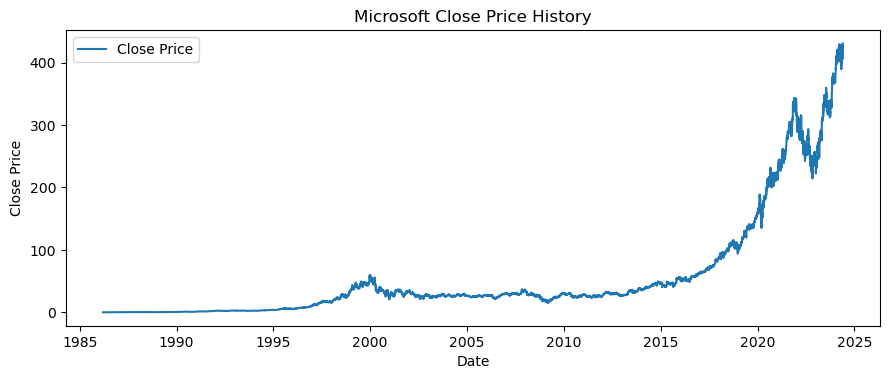

In [8]:
# Plot the results
plt.figure(figsize=(9, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'].values, label='Close Price')
plt.legend()
plt.title('Microsoft Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

In [9]:
# Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(data['Close'].values)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print('Series is not stationary, consider differencing.')
else:
    print('Series is stationary.')

ADF Statistic: 4.501666363487712
p-value: 1.0
Series is not stationary, consider differencing.


In [10]:
data['Close'] = data['Close'].diff()
data = data.dropna()

In [11]:
# Split the data into features (X) and target variable (y)
X = data.drop(columns=['Close', 'Adj Close'])  # Excluding 'Close' and 'Adj Close' columns as features
y = data['Close']


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  

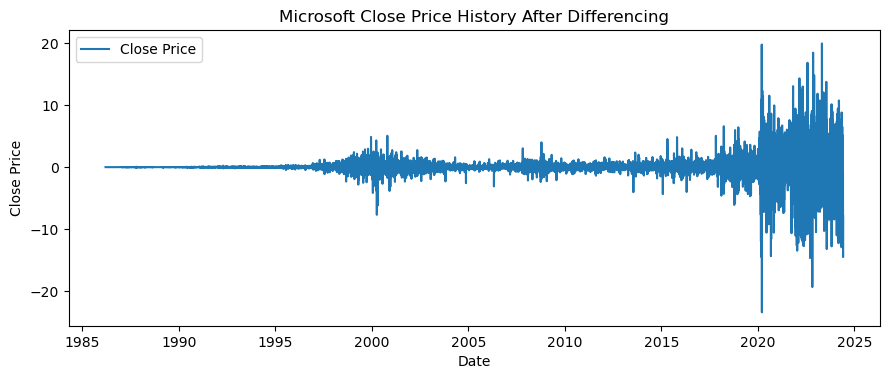

In [13]:
# Plot the results
plt.figure(figsize=(9, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(y.index, y, label='Close Price')
plt.legend()
plt.title('Microsoft Close Price History After Differencing')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

## Traditional Models


#### Linear regression

In [14]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [240]:
# Predict on the test set
y_pred = lr_model.predict(X_test)

In [241]:
timeseries_evaluation_metrics_func(y_test,y_pred)

Evaluation metric results:-
MSE is : 7.636902443291496
MAE is : 1.6891786405833171
RMSE is : 2.7634946070675617
MAPE is : 224.63094150394483
R2 is : 0.47314257536824467



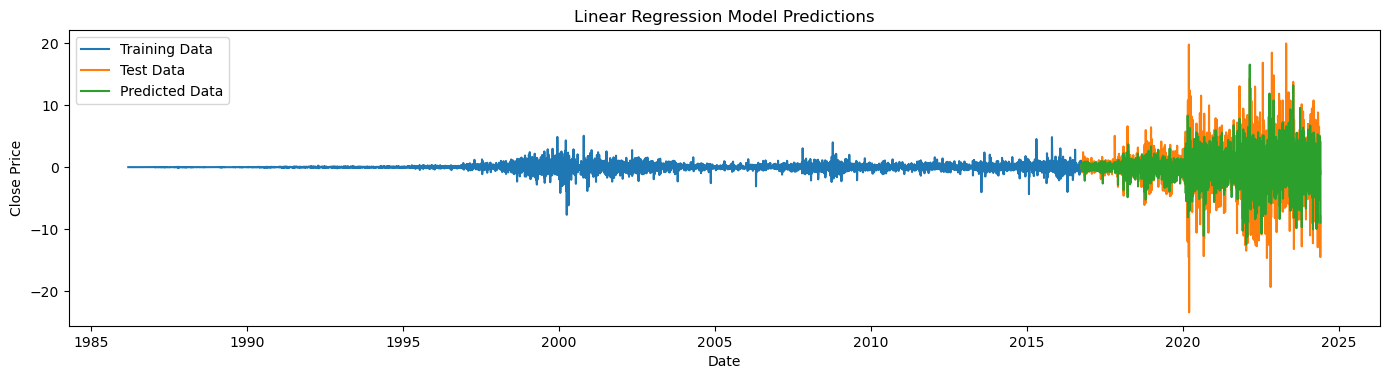

In [242]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(y_test.index, y_pred, label='Predicted Data')
plt.legend()
plt.title('Linear Regression Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

#### Arima

In [243]:
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

In [244]:
train_data = train_data.drop(columns = ["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)
test_data = test_data.drop(columns = ["Open", "High", "Low", "Adj Close", "Volume"], axis = 1)

In [245]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [246]:
# Use auto_arima to find the best ARIMA model
arima_model = auto_arima(train_scaled, seasonal=False, trace=True,
                         error_action='ignore', suppress_warnings=True,
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=7.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14119.544, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4880.190, Time=1.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-27314.052, Time=2.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27179.988, Time=2.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=5.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1521.638, Time=1.71 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-27433.040, Time=1.36 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-27434.927, Time=3.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-27432.841, Time=1.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-27433.270, Time=3.94 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27434.983, Time=0.67 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   :

In [247]:
forecast_period = len(test_data)
y_pred_arima = arima_model.predict(n_periods=forecast_period)
y_pred_arima = scaler.inverse_transform(y_pred_arima.reshape(1, -1))

In [248]:
timeseries_evaluation_metrics_func(test_data.values.T,y_pred_arima)

Evaluation metric results:-
MSE is : 14.525422776325678
MAE is : 2.5076780100995446
RMSE is : 3.811223265085067
MAPE is : 99.91251052310695
R2 is : nan



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


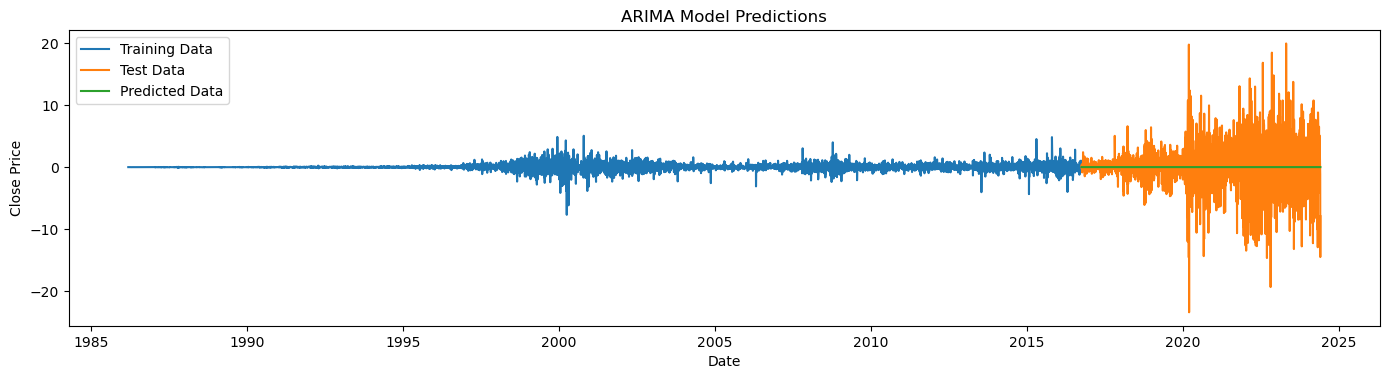

In [249]:
# Plot the results
plt.figure(figsize=(14, 7))

# Plot true vs predicted values
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data.values, label='Training Data')
plt.plot(test_data.index, test_data.values, label='Test Data')
plt.plot(test_data.index, y_pred_arima.T, label='Predicted Data')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

## DeepLearning Models

#### LSTM

In [253]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [254]:
features = ['Open', 'High', 'Low', 'Volume']
features_transformer = MinMaxScaler()
Close_transformer = MinMaxScaler()

features_transformer = features_transformer.fit(train[features].to_numpy())
Close_transformer = Close_transformer.fit(train[['Close']])

train.loc[:, features] = features_transformer.transform(train[features].to_numpy())
train['Close'] = Close_transformer.transform(train[['Close']])
test.loc[:, features] = features_transformer.transform(test[features].to_numpy())
test['Close'] = Close_transformer.transform(test[['Close']])

C:\Users\Tony\AppData\Local\Temp\ipykernel_27416\2390795849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = Close_transformer.transform(train[['Close']])
C:\Users\Tony\AppData\Local\Temp\ipykernel_27416\2390795849.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = Close_transformer.transform(test[['Close']])


In [255]:
time_steps = 24
# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print('X_train:', X_train.shape, 'Y_train:', y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', y_test.shape)

X_train: (7680, 24, 6) Y_train: (7680,)
X_test: (1903, 24, 6) Y_test: (1903,)


In [302]:
#Setting the return_sequences=True makes each cell per timestep emit a signal.
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.LSTM(128, activation ='relu',input_shape=X_train.shape[-2:],return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(128, activation ='relu',return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(units=128,activation ='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=1),])
model_LSTM.summary()

model_LSTM.compile(optimizer= 'adam', loss='mse')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 24, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 24, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,417 (1.27 MB)

 Trainable params: 332,417 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [303]:
es = EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

In [304]:
lstm_history = model_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,batch_size=64, verbose=1,callbacks=es)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 15.4220 - val_loss: 142.4729
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.3271 - val_loss: 11.6986
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 43.3330 - val_loss: 317.9033
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 7.2970 - val_loss: 46.0802
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1.0074 - val_loss: 21.0682
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1.1905 - val_loss: 110.8119
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.5372 - val_loss: 6.8103
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.2246 - val_loss: 2.6287
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0808 - val_loss: 4.2448
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0572 - val_loss: 0.4481
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0567 - val_loss: 2.6742
Epoch 12/50
120/120 ━━━━━━━━━━

In [305]:
y_pred_lstm = model_LSTM.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [306]:
timeseries_evaluation_metrics_func(y_test, y_pred_lstm)

Evaluation metric results:-
MSE is : 0.09290851216934627
MAE is : 0.20774523799926103
RMSE is : 0.30480897652357003
MAPE is : 113.13963846088033
R2 is : -0.029369659621578892



In [307]:
model_LSTM.save('LSTM_model_0.092.h5')

### GRU

In [262]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.GRU(128, activation ='relu',input_shape=X_train.shape[-2:],return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.GRU(128, activation ='relu',return_sequences=True),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.GRU(units=128,activation ='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=1),])
model_GRU.summary()

model_GRU.compile(optimizer= 'adam', loss='mse')

C:\Users\Tony\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 24, 128)             │          52,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 24, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,497 (978.50 KB)

 Trainable params: 250,497 (978.50 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
gru_history = model_GRU.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,batch_size=64, verbose=1,callbacks=es)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 0.1207 - val_loss: 0.2986
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0058 - val_loss: 0.1044
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0045 - val_loss: 0.0990
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0041 - val_loss: 0.1235
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0038 - val_loss: 0.1906
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0035 - val_loss: 0.1192
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0034 - val_loss: 0.1050
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0034 - val_loss: 0.1535
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0031 - val_loss: 0.1010
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0030 - val_loss: 0.0935
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0031 - val_loss: 0.1024
Epoch 12/50
120/120 ━━━━━━━━━━

In [264]:
y_pred_GRU = model_GRU.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


In [265]:
timeseries_evaluation_metrics_func(y_test,y_pred_GRU)

Evaluation metric results:-
MSE is : 0.09089144580395812
MAE is : 0.20001377470031387
RMSE is : 0.3014820820612033
MAPE is : 114.06039974971947
R2 is : -0.007021794291551586



In [266]:
model_GRU.save('GRU_model_0.09.h5')

### TCN

In [333]:
I = Input(shape=(X_train.shape[1], X_train.shape[2]))
tcn_layer = TCN(nb_filters=32,
                     kernel_size=4,
                     nb_stacks=4,
                     dilations=(2, 4, 8,16),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.2,
                     activation='relu',
                     kernel_initializer='glorot_uniform',
                     use_batch_norm=False,
                     use_layer_norm=False,
                     return_sequences = False)(I)
    
output = Dense(1, activation='linear')(tcn_layer)
model_tcn = Model(inputs=[I], outputs=[output])
model_tcn.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 24, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_5 (TCN)                          │ (None, 32)                  │         148,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,193 (578.88 KB)

 Trainable params: 148,193 (578.88 KB)

 Non-trainable params: 0 (0.00 B)

In [334]:
model_tcn.compile(loss='mse', optimizer='adam')
tcn_history = model_tcn.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=2,epochs=100,batch_size=64)


Epoch 1/100
120/120 - 19s - 157ms/step - loss: 1.3709 - val_loss: 0.1585
Epoch 2/100
120/120 - 4s - 34ms/step - loss: 0.0416 - val_loss: 0.1228
Epoch 3/100
120/120 - 4s - 34ms/step - loss: 0.0131 - val_loss: 0.0936
Epoch 4/100
120/120 - 4s - 34ms/step - loss: 0.0077 - val_loss: 0.1010
Epoch 5/100
120/120 - 4s - 34ms/step - loss: 0.0062 - val_loss: 0.1083
Epoch 6/100
120/120 - 4s - 34ms/step - loss: 0.0050 - val_loss: 0.0996
Epoch 7/100
120/120 - 4s - 34ms/step - loss: 0.0046 - val_loss: 0.1023
Epoch 8/100
120/120 - 4s - 34ms/step - loss: 0.0036 - val_loss: 0.1258
Epoch 9/100
120/120 - 4s - 34ms/step - loss: 0.0033 - val_loss: 0.1221
Epoch 10/100
120/120 - 4s - 34ms/step - loss: 0.0028 - val_loss: 0.0946
Epoch 11/100
120/120 - 4s - 37ms/step - loss: 0.0027 - val_loss: 0.1016
Epoch 12/100
120/120 - 4s - 37ms/step - loss: 0.0025 - val_loss: 0.0957
Epoch 13/100
120/120 - 4s - 35ms/step - loss: 0.0024 - val_loss: 0.1062
Epoch 14/100
120/120 - 4s - 35ms/step - loss: 0.0023 - val_loss: 0.1000

In [335]:
y_pred_tcn = model_tcn.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [336]:
timeseries_evaluation_metrics_func(y_test,y_pred_tcn)

Evaluation metric results:-
MSE is : 0.09150472811351532
MAE is : 0.20180840526969876
RMSE is : 0.30249748447469
MAPE is : 110.2253129023812
R2 is : -0.013816588304506494



In [280]:
model_tcn.save('TCN_model_0.090.h5')